In [1]:
import torch
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
from random import randint
from IPython.display import clear_output

import numpy as np
import pylab as pl

from src import *

/home/lettera/anaconda3/lib/python3.8/site-packages/torch/package/_directory_reader.py:17: UserWarning: Failed to initialize NumPy: module compiled against API version 0xe but this version of numpy is 0xd (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:68.)
  _dtype_to_storage = {data_type(0).dtype: data_type for data_type in _storages}


In [2]:
N_CHANNELS = 15        # Number of CA state channels
TARGET_PADDING = 8     # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5

torch.backends.cudnn.benchmark = True # Speeds up things

In [3]:
# Imports the target emoji
target = read_image("images/firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

RuntimeError: Numpy is not available

In [4]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target = target.to(device)

model = MultipleCA(N_CHANNELS, n_CAs=2, device=device)

In [5]:
# checkpoint = {
#     "state_dict": model.CAs[1].state_dict(),
#     "pool": pool.images,
#     "loss": model.losses
# }

# torch.save(checkpoint, "330_epoch.pt")

In [6]:
def state_to_image(x, mask_channels):
    alpha = x[:, mask_channels].sum(dim=1).unsqueeze(1)
    return torch.cat((x[:, :3], alpha), dim=1)

In [7]:
for param in model.CAs[0].parameters():
    param.requires_grad = False

generator = VirusGenerator(N_CHANNELS, IMAGE_SIZE, 2, model, virus_rate=0.9, iter_func=ExponentialSampler(min=48, max=64))
pool = SamplePool(POOL_SIZE, generator)

In [8]:
wandb.init(project="quick_virus", entity="neural_ca")

wandb: Currently logged in as: lettera (use `wandb login --relogin` to force relogin)


In [8]:
wandb.init(mode="disabled")

In [9]:
params = model.CAs[1].parameters()

optimizer = torch.optim.Adam(params, lr=2e-3)
criterion = NCALoss(pad(target, TARGET_PADDING), torch.nn.MSELoss, alpha_channels=[15, 16])
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.3)

model.train_CA(optimizer, criterion, pool, n_epochs=120, skip_update=2, batch_size=8,
               scheduler=scheduler, kind="persistent", skip_damage=1, n_max_losses=1,
               evolution_iters=(16, 32))

KeyboardInterrupt: 

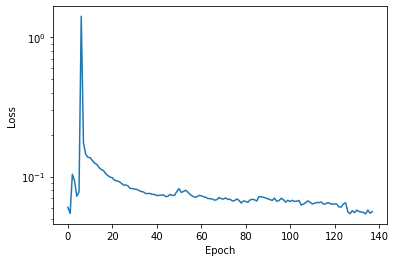

In [7]:
pl.plot(model.losses)
pl.xlabel("Epoch")
pl.ylabel("Loss")
pl.yscale("log")
pl.show()
# pl.savefig(fname="perturbation_regeneration_l=1_side=20_losses.png", dpi=200)

In [21]:
pl.matshow(inputs[0, -1].cpu()>0.1)
pl.matshow(inputs[0, -2].cpu()>0.1)

NameError: name 'inputs' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


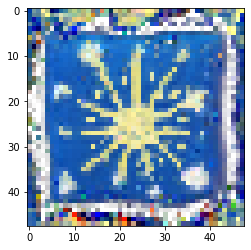

In [14]:
def state_to_image(x, mask_channels):
    alpha = x[:, mask_channels].sum(dim=1).unsqueeze(1)
    return torch.cat((x[:, :3], alpha), dim=1)

inputs = pool.sample(1)[0].detach().cuda()

inputs = model.evolve(inputs, 80)


imshow(state_to_image(inputs, [-1, -2])[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


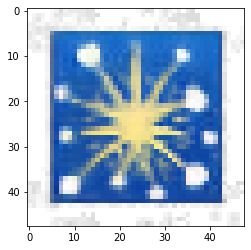

In [81]:
def state_to_image(x, mask_channels):
    alpha = x[:, mask_channels].sum(dim=1).unsqueeze(1)
    return torch.cat((x[:, :3], alpha), dim=1)

inputs = pool.sample(1)[0].detach().cuda()

imshow(state_to_image(inputs, [-1, -2])[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


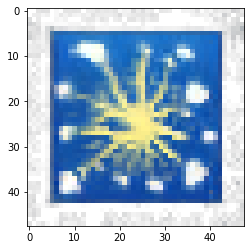

In [84]:
# recursive forward-pass
inputs = model.evolve(inputs, 30)

imshow(state_to_image(inputs, [-1, -2])[0])

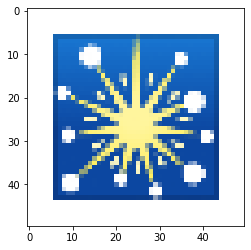

In [21]:
# Plots the true emoji
imshow(TraintoFloat(pad(target, 10, -1)))